In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns

In [2]:
tempos = ["010", "020", "030"]
tempoEstavel = 150
seeds = ["10", "20"]
quantidadeIperfs = 2500
salvarGraficos = True
#Tabela tempo->medicao
#010 -> 100=18 250=48
#020 -> 150=28 300=58
#030 -> 200=38 350=68
intervalosEstaveis = [("010", 18, 48), ("020", 28, 58), ("030", 38, 68)]
#intervalosEstaveis = [("010", 28, 68), ("020", 48, 78), ("030", 58, 88)]
intervalosTempo = [("010", 100, 250), ("020", 150, 300), ("030", 200, 350)]

In [3]:
#Adicionando colunas com a medicao
mHW = 0
mSW = 0
def teste (nomeSwitch):
    global mHW
    global mSW
    if (nomeSwitch == "HW"):
        mHW += 1
        return mHW
    if (nomeSwitch == "SW"):
        mSW += 1
        return mSW

#Lendo os arquivos info (report do controlador)
dfPI_info = pd.DataFrame()
dfSW_info = pd.DataFrame()
i = 1
for seed in seeds:
    mHW = 0
    mSW = 0
    for tempo in tempos:
        mHW = 0
        mSW = 0
        dfPI_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/info_parimpar.txt", sep=" ")
        dfPI_infoTemp['TempoChegada'] = tempo
        dfPI_infoTemp['Seed'] = seed
        dfPI_infoTemp['Metodo'] = 'Estático'
        dfPI_infoTemp['Medicao'] = dfPI_infoTemp['Switch'].apply(teste)
        dfPI_info = pd.concat([dfPI_info, dfPI_infoTemp], ignore_index=True)
        mHW = 0
        mSW = 0
        dfSW_infoTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/info_sw.txt", sep=" ")
        dfSW_infoTemp['TempoChegada'] = tempo
        dfSW_infoTemp['Seed'] = seed
        dfSW_infoTemp['Metodo'] = 'Dinâmico'
        dfSW_infoTemp['Medicao'] = dfSW_infoTemp['Switch'].apply(teste)
        dfSW_infoTemp.rename(columns={'VezesBloqueado':'RegrasBloqueadas'}, inplace=True)
        dfSW_info = pd.concat([dfSW_info, dfSW_infoTemp], ignore_index=True)
    i += 1
dfTotal_info = pd.concat([dfPI_info, dfSW_info], ignore_index=True)
#dfTotal_info.to_csv(r'pandas.txt', index=None, sep=' ', mode='a')

In [4]:
#Lendo todos os CSVs dos iperfs
dfPI_csv = pd.DataFrame()
dfSW_csv = pd.DataFrame()
i = 1
for seed in seeds:
    for tempo in tempos:
        dfPI_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_pi"+(tempo)+"/teste"+(str(i))+"_pi"+(tempo)+".csv")
        dfPI_csvTemp['TempoChegada'] = tempo
        dfPI_csvTemp['Seed'] = seed
        dfPI_csvTemp['Metodo'] = 'PI'
        dfPI_csv = pd.concat([dfPI_csv, dfPI_csvTemp], ignore_index=True)
        dfSW_csvTemp = pd.read_csv("../Saidas/teste"+(str(i))+"_sw"+(tempo)+"/teste"+(str(i))+"_sw"+(tempo)+".csv")
        dfSW_csvTemp['TempoChegada'] = tempo
        dfSW_csvTemp['Seed'] = seed
        dfSW_csvTemp['Metodo'] = 'SW'
        dfSW_csv = pd.concat([dfSW_csv, dfSW_csvTemp], ignore_index=True)
    i += 1
del dfPI_csv['?']
del dfSW_csv['?']
del dfSW_csv['Timestamp']
del dfPI_csv['Timestamp']
dfServerPI = dfPI_csv[dfPI_csv.IpOri == '10.1.0.1']
dfServerSW = dfSW_csv[dfSW_csv.IpOri == '10.1.0.1']
dfServer = pd.concat([dfServerPI, dfServerSW], ignore_index=True)

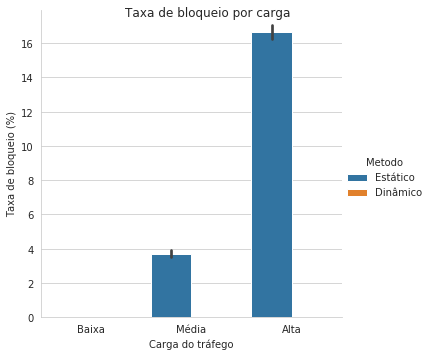

In [5]:
#Grafico de bloqueados metodo par impar
gpb = dfTotal_info.groupby(["Seed", "TempoChegada", "Metodo"]).max()
gpb.reset_index(inplace=True)
gpb["TaxaBloqueio"] = gpb["RegrasBloqueadas"]/2/float(quantidadeIperfs)*100
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="TaxaBloqueio", kind="bar", hue="Metodo", hue_order=["Estático", "Dinâmico"],order=["030", "020", "010"], ci=95, data=gpb)
sns_plt.fig.suptitle('Taxa de bloqueio por carga')
sns_plt.set_axis_labels("Carga do tráfego", "Taxa de bloqueio (%)").set_xticklabels(["Baixa", "Média", "Alta"])
if (salvarGraficos):
    sns_plt.savefig("TaxaBloqueio.pdf")

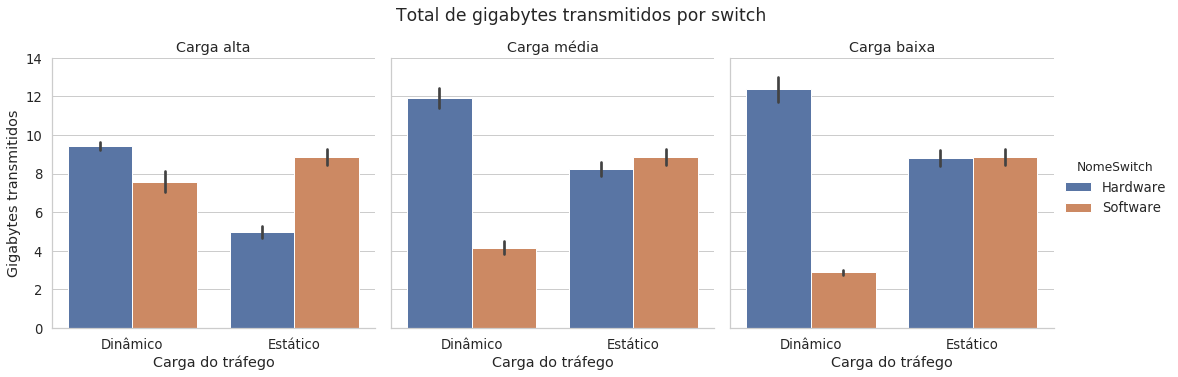

In [6]:
#Trafego em cada switch
gpb = dfTotal_info.groupby(["Metodo", "TempoChegada", "Seed", "Switch"]).max()
sns.set(font_scale=1.2, style="whitegrid")
#sns.set_style("whitegrid")
gpb["GBEnv"] = gpb["BytesEnviados"]/1e9
gpb.reset_index(inplace=True)
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(x="Metodo", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeTempo", hue="NomeSwitch")
#sns_plt = sns.catplot(x="TempoChegada", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeSwitch", hue="Metodo")
sns_plt.set(ylim=(0, 14))
sns_plt.fig.suptitle('Total de gigabytes transmitidos por switch', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Gigabytes transmitidos")
sns_plt.set_titles("Carga {col_name}")
if (salvarGraficos):
    sns_plt.savefig("totalgbporswitch.pdf")

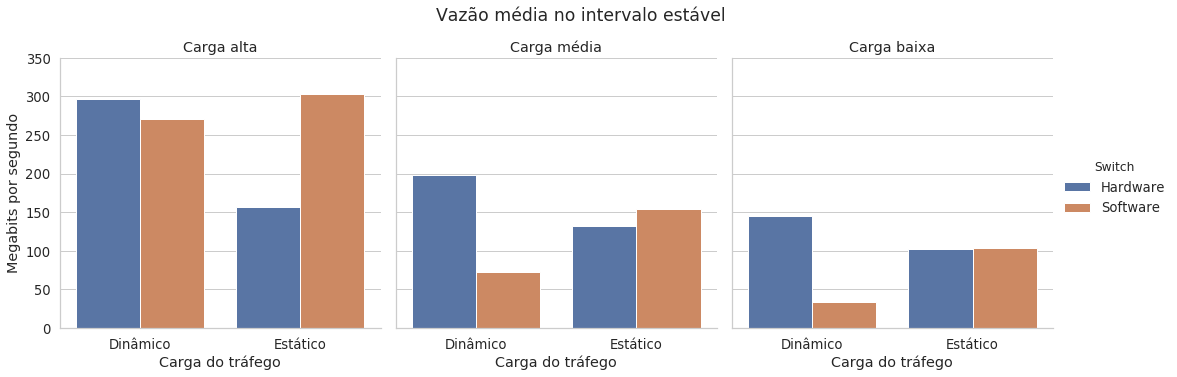

In [7]:
#Trafego em cada switch no intervalo estavel
gpb = dfTotal_info.groupby(["Metodo", "TempoChegada", "Switch", "Medicao"]).mean()
gpb['Total'] = 0
gpb.reset_index(inplace=True)
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and (row['Medicao'] != b and row['Medicao'] != c)):
            gpb.drop(index, inplace=True)
#Calculando o total transmitido no intervalo estavel
#(bytesenviados no fim-inicio porque bytesenviados é acumulativo)
totalHW = 0
totalSW = 0
for index, row in gpb.iterrows():
    for a, b, c in intervalosEstaveis:
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "HW"):
            totalHW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "HW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalHW
            totalHW = 0
        if (row["TempoChegada"] == a and row['Medicao'] == b and row['Switch'] == "SW"):
            totalSW = row["BytesEnviados"]
        if (row["TempoChegada"] == a and row['Medicao'] == c and row['Switch'] == "SW"):
            gpb.at[index, 'Total'] = row["BytesEnviados"] - totalSW
            totalSW = 0
gpb = gpb[gpb.Total != 0]
#Plotando grafico
sns.set(font_scale=1.2, style="whitegrid")
gpb["MbSeg"] = gpb["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb["NomeSwitch"] = gpb["Switch"].map({"SW": "Software", "HW": "Hardware"})
gpb["NomeTempo"] = gpb["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="NomeTempo", hue="NomeSwitch")
#sns_plt = sns.catplot(x="TempoChegada", y="GBEnv", kind="bar", ci=95, data=gpb, col="NomeSwitch", hue="Metodo")
sns_plt.set(ylim=(0, 350))
sns_plt.fig.suptitle('Vazão média no intervalo estável', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
sns_plt.set_titles("Carga {col_name}")
sns_plt._legend.set_title("Switch")
if (salvarGraficos):
    sns_plt.savefig("VazaoMediaIntervaloEstavelPorSwitch.pdf")

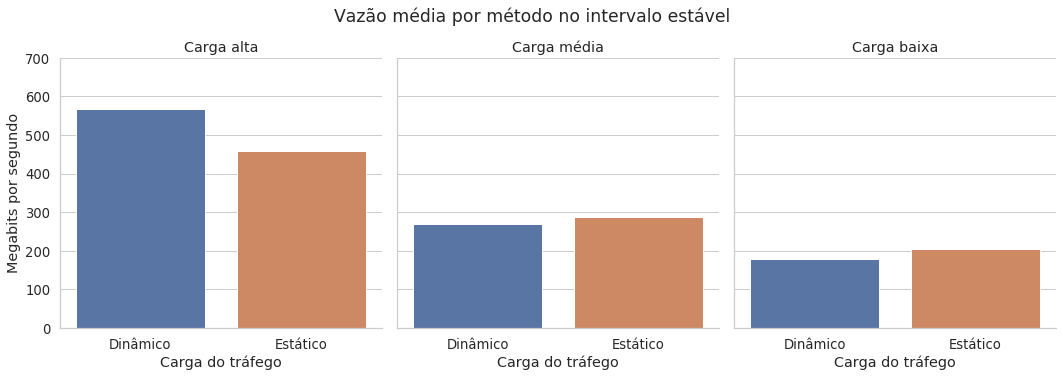

In [8]:
gpb2 = gpb.groupby(["Metodo", "TempoChegada"]).sum()
gpb2["MbSeg"] = gpb2["Total"]/125000/tempoEstavel #Divide por 125000 para bytes->megabits
gpb2.reset_index(inplace=True)
sns.set(font_scale=1.2, style="whitegrid")
gpb2["NomeTempo"] = gpb2["TempoChegada"].map({"010": "alta", "020": "média", "030": "baixa"})
sns_plt = sns.catplot(x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb2, col="NomeTempo")
sns_plt.set(ylim=(0, 700))
sns_plt.fig.suptitle('Vazão média por método no intervalo estável', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
sns_plt.set_titles("Carga {col_name}")
if (salvarGraficos):
    sns_plt.savefig("VazaoIntervaloEstavelPorMetodo.pdf")

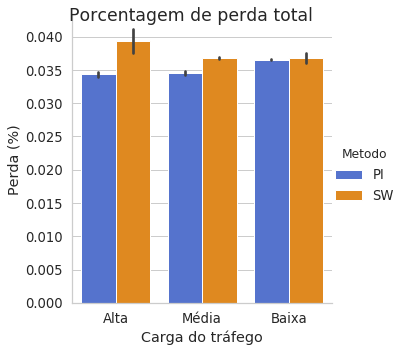

In [9]:
#Perda de pacotes total
gpb = dfServer.groupby(["Metodo", "TempoChegada", "Seed"]).sum()
gpb["PPerda"] = (gpb["PctPerdido"]/gpb["PctEnv"])*100
gpb
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="PPerda", kind="bar", ci=95, data=gpb, hue="Metodo", palette=sns.color_palette(['royalblue', 'darkorange']))
sns_plt.fig.suptitle('Porcentagem de perda total')
sns_plt.set_axis_labels("Carga do tráfego", "Perda (%)").set_xticklabels(["Alta", "Média", "Baixa"])
if (salvarGraficos):
    sns_plt.savefig("totalperda.pdf")

In [10]:
#Pegando portas no intervalo estavel
dfIperf = pd.DataFrame()
for i in range(len(seeds)):
    dfIperf_temp = pd.read_csv("../Saidas/teste"+(str(i+1))+"_pi010/iperfs.txt", sep="\t")
    dfIperf_temp['Seed'] = seeds[i]
    dfIperf = pd.concat([dfIperf, dfIperf_temp], ignore_index=True)
portasEstaveis010 = []
portasEstaveis020 = []
portasEstaveis030 = []
for a, b, c in intervalosTempo:
    for index, row in dfIperf.iterrows():
        if (row['Inicio(seg)'] >= b and row['Inicio(seg)'] <= c):
            if (a == "010"):
                portasEstaveis010.append(int(row['PCli']))
            elif (a == "020"):
                portasEstaveis020.append(int(row['PCli']))
            elif (a == "030"):
                portasEstaveis030.append(int(row['PCli']))

In [11]:
gpb = dfServer.groupby(["Metodo", "PortaOri", "PortaDest", "TempoChegada"]).mean()
gpb.reset_index(inplace=True)
dfEstavel = gpb
for index, row in gpb.iterrows():
    if (not(int(row['PortaDest']) in portasEstaveis010) and row['TempoChegada'] == "010"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis020) and row['TempoChegada'] == "020"):
        dfEstavel.drop(index, inplace=True)
    elif (not(int(row['PortaDest']) in portasEstaveis030) and row['TempoChegada'] == "030"):
        dfEstavel.drop(index, inplace=True)

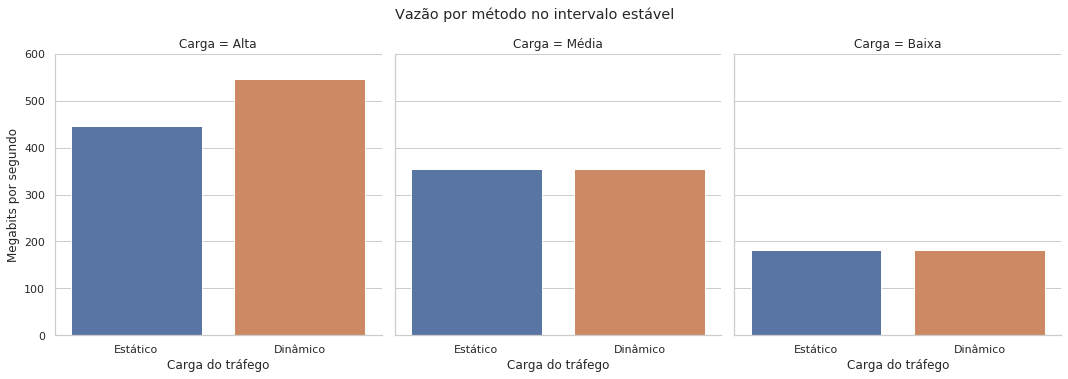

In [12]:
#Trafego no intervalo estavel em cada metodo
gpb = dfEstavel.groupby(["Metodo","TempoChegada"]).sum()
gpb["MbSeg"] = gpb["BytesEnv"]/125000/tempoEstavel
gpb.reset_index(inplace=True)
sns.set(font_scale=1, style="whitegrid")
gpb["Carga"] = gpb["TempoChegada"].map({"010": "Alta", "020": "Média", "030": "Baixa"})
gpb["NomeMetodo"] = gpb["Metodo"].map({"SW": "Dinâmico", "PI": "Estático"})
sns_plt = sns.catplot(x="NomeMetodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="Carga")
#sns_plt = sns.catplot(x="Metodo", y="MbSeg", kind="bar", ci=95, data=gpb, col="NomeTempo")
sns_plt.fig.suptitle('Vazão por método no intervalo estável', y=1.05)
sns_plt.set_axis_labels("Carga do tráfego", "Megabits por segundo")
sns_plt.set(ylim=(0, 600))
if (salvarGraficos):
    sns_plt.savefig("VazaoIntervaloEstavelCSV.pdf")

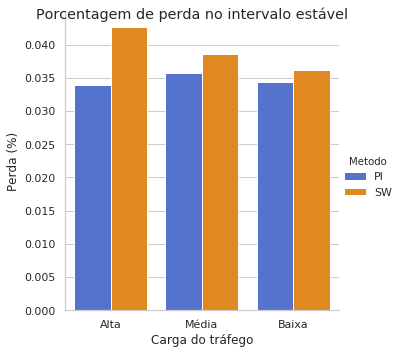

In [13]:
#Perda de pacotes no intervalo estavel
gpb = dfEstavel.groupby(["Metodo", "TempoChegada"]).sum()
gpb["PPerda"] = (gpb["PctPerdido"]/gpb["PctEnv"])*100
gpb.reset_index(inplace=True)
sns.set_style("whitegrid")
sns_plt = sns.catplot(x="TempoChegada", y="PPerda", kind="bar", ci=99.999, data=gpb, hue="Metodo", palette=sns.color_palette(['royalblue', 'darkorange']))
sns_plt.fig.suptitle('Porcentagem de perda no intervalo estável')
sns_plt.set_axis_labels("Carga do tráfego", "Perda (%)").set_xticklabels(["Alta", "Média", "Baixa"])
if (salvarGraficos):
    sns_plt.savefig("perdaestavel.pdf")

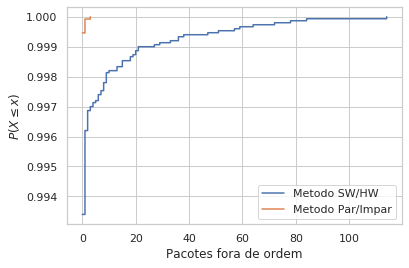

In [14]:
#CDF dos pacotes fora de ordem --- NÃO DIVIDE POR SEED
a = dfServerSW['ForaOrdem'].tolist()
b = dfServerPI['ForaOrdem'].tolist()
x = np.sort(a)
x1 = np.sort(b)
ecdf = sm.distributions.ECDF(a)
ecdf1 = sm.distributions.ECDF(b)
y = ecdf(x)
y1 = ecdf1(x1)
plt.step(x, y, where='post', label="Metodo SW/HW")
plt.step(x1, y1, where='post', label="Metodo Par/Impar")
plt.ylabel(r'$P(X \leq x)$')
plt.xlabel(r'Pacotes fora de ordem')
plt.legend()
if (False):
    plt.savefig('foraordem.pdf')
plt.show()